Data downloaded from: https://storage.googleapis.com/openimages/web/extended.html
(I only downloaded set 1)

## Data preparation

Creating trian, valid and test folder with 3 classes.

Photos in train per class: 400

Photos in valid per class: 100

Photos in test per class: 100

In [ ]:
import tarfile

with tarfile.open('extended-crowdsourced-images-0.tar.gz', 'r:gz') as tar:
    tar.extractall()

In [ ]:
import os

image_path = 'crowdsource_images-00000-of-00010'
image_names = os.listdir(image_path)
image_names = [x[:-4] for x in image_names]
image_names[:10]

['0004523c0de50d7d',
 '0008f8841ed74d12',
 '000909066ae45299',
 '000c6ce6ab399e09',
 '000d6e463633c452',
 '000d8cd104d1511b',
 '000dc94bce1c855f',
 '000de0e6841e2258',
 '000e7de509a6935a',
 '000f6eb260ff4dee']

In [ ]:
import pandas as pd

label_df = pd.read_csv('extended-crowdsourced-image-labels.csv')
label_df.head()

,ImageID,Source,LabelName,Confidence
0,afbe6bee0226cd91,tag-verification,/m/07c52,1
1,96d65179732b59ec,tag-verification,/m/02w3_2,1
2,96d65179732b59ec,tag-verification,/m/09j2d,1
3,96d65179732b59ec,verification,/m/01g317,1
4,d7d678178da7958e,verification,/m/014f__,0


In [ ]:
class_df = pd.read_csv('class-descriptions-boxable.csv', header=None)
class_df.columns = ['label', 'class']
class_df.head()

,label,class
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [ ]:
# images that can be found in our downloaded dataset
our_images_df = label_df[label_df['ImageID'].isin(image_names)]
our_images_df = our_images_df[our_images_df['Confidence'] == 1]
our_images_df = our_images_df.drop_duplicates(subset=['ImageID', 'LabelName'])
our_images_df.shape

(80746, 4)

In [ ]:
number_of_images_df = our_images_df.groupby(['LabelName']).count()
number_of_images_df = number_of_images_df.sort_values(['ImageID'], ascending=False).drop(columns=['Source', 'Confidence'])
number_of_images_df = number_of_images_df.reset_index().rename(columns={'LabelName':'label', 'ImageID':'count'})
number_of_images_df.head()

,label,count
0,/m/01g317,14411
1,/m/07s6nbt,3154
2,/m/07j7r,1676
3,/m/05s2s,1633
4,/m/01c8br,981


In [ ]:
# Finding out how many pictures we have from each class that have atleast 600 pictures
merged = pd.merge(number_of_images_df, class_df, on='label')
merged[merged['count'] >= 600]

,label,count,class
0,/m/01g317,14411,Person
1,/m/07j7r,1676,Tree
2,/m/05s2s,1633,Plant
3,/m/0k1tl,686,Pen


In [ ]:
# Choosing 3 of our choice
three_classes = list(merged['class'].iloc[[0, 2, 3]])
three_labels = list(merged['label'].iloc[[0, 2, 3]])

Create folders and copy the pictures into the right ones

---



In [ ]:
if not os.path.isdir('data'):
    os.mkdir('data')
    os.mkdir(os.path.join('data', 'train'))
    os.mkdir(os.path.join('data', 'valid'))
    os.mkdir(os.path.join('data', 'test'))
    for i in range(3):
        os.mkdir(os.path.join('data', 'train', three_classes[i]))
        os.mkdir(os.path.join('data', 'valid', three_classes[i]))
        os.mkdir(os.path.join('data', 'test', three_classes[i]))

In [ ]:
import shutil

def copy_images(image_ids, from_p, to_p):
    for image_id in image_ids:
        from_path = os.path.join(from_p, image_id + '.jpg')
        to_path = os.path.join(os.path.join(to_p, image_id + '.jpg'))
        shutil.copyfile(from_path, to_path)

for i in range(3):
    image_ids = list(our_images_df[our_images_df['LabelName'] == three_labels[i]]['ImageID'][:600])
    
    copy_images(image_ids[:400], image_path, os.path.join('data', 'train', three_classes[i]))
    copy_images(image_ids[400:500], image_path, os.path.join('data', 'valid', three_classes[i]))
    copy_images(image_ids[500:], image_path, os.path.join('data', 'test', three_classes[i]))

## Creating and training the model

In [4]:
# This is only here for me to run from colab

import shutil, os, zipfile

COLAB = True
if COLAB:
  DIR = '/content/drive/My Drive/Colab Notebooks/Deep learning/Image transfer learning'
  shutil.copyfile(os.path.join(DIR, 'data.zip'), 'data.zip')
  with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
# Hyperparameters

NUM_CLASSES = 3
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

LR = 0.0001
TRAIN_EPOCHS = 20
TUNE_EPOCHS = 5
DROPOUT = 0.2

PATIENCE = 3
SAVED_MODEL_PATH = 'model.hdf5'

FINE_TUNE_FROM = 125

IMAGE_SHAPE = IMAGE_SIZE + (3,)

Creating datagenerators

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

# no special data augmentation because the pictures are already quite tricky
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory('data/train',
                                       target_size=IMAGE_SIZE,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True)
valid_gen = datagen.flow_from_directory('data/valid',
                                       target_size=IMAGE_SIZE,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True)
test_gen = datagen.flow_from_directory('data/test',
                                       target_size=IMAGE_SIZE,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False)

Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


Creating the model

In [5]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(input_shape=IMAGE_SHAPE, include_top=False)
base_model.trainable = False

inputs = Input(shape=IMAGE_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(lr=LR),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Training the model

In [6]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

def get_callbacks():
  log_dir = 'logs/'

  tb = TensorBoard(log_dir=log_dir, histogram_freq=1)
  early_stopping = EarlyStopping(patience=PATIENCE, verbose=0)
  checkpointer = ModelCheckpoint(filepath=SAVED_MODEL_PATH, save_best_only=True, verbose=0)

  return [tb, early_stopping, checkpointer]

STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size

history = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=TRAIN_EPOCHS,
                    callbacks=get_callbacks())

Epoch 1/20
 1/37 [..............................] - ETA: 0s - loss: 1.5132 - accuracy: 0.3438WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
37/37 [==============================] - 36s 968ms/step - loss: 1.2032 - accuracy: 0.4872 - val_loss: 0.8210 - val_accuracy: 0.6458
Epoch 2/20
37/37 [==============================] - 35s 943ms/step - loss: 0.7515 - accuracy: 0.6832 - val_loss: 0.6035 - val_accuracy: 0.7396
Epoch 3/20
37/37 [==============================] - 35s 952ms/step - loss: 0.5587 - accuracy: 0.7740 - val_loss: 0.4647 - val_accuracy: 0.8056
Epoch 4/20
37/37 [==============================] - 35s 948ms/step - loss: 0.4365 - accuracy: 0.8382 - val_loss: 0.4246 - val_accuracy: 0.8264
Epoch 5/20
37/37 [==============================] - 35s 947ms/step -

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics(histories):
  '''
  Function for plotting the loss and accuracy of models that we run.
  So its not only visible from tensorboard.
  '''
  
  acc, val_acc, loss, val_loss = [], [], [], []
  for history in histories:
    acc += history.history['accuracy']
    val_acc += history.history['val_accuracy']

    loss += history.history['loss']
    val_loss += history.history['val_loss']

  epochs = [x+1 for x in range(len(acc))]

  chart1, ax1 = plt.subplots()
  acc_data = pd.DataFrame({'epoch':epochs, 'train_acc':acc, 'valid_acc':val_acc})
  sns.lineplot(x='epoch', y='value', hue='variable', data=pd.melt(acc_data, ['epoch']), ax=ax1)

  chart2, ax2 = plt.subplots()
  loss_data = pd.DataFrame({'epoch':epochs, 'train_loss':loss, 'valid_loss':val_loss})
  sns.lineplot(x='epoch', y='value', hue='variable', data=pd.melt(loss_data, ['epoch']))

  return [chart1, chart2]

[<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

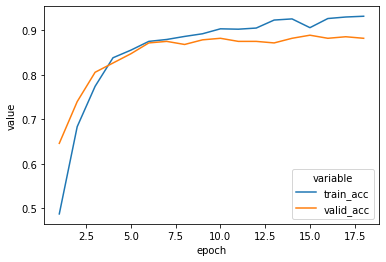

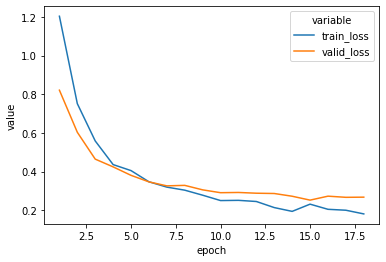

In [9]:
plot_metrics([history])

Unfreeze some of the layers of the pretrained ResNet model and fine tune the model

In [10]:
# Reload best model from previous train
model.load_weights(SAVED_MODEL_PATH)

base_model.trainable = True

# Freeze all the layers before the `FINE_TUNE_FROM` layer
for layer in base_model.layers[:FINE_TUNE_FROM]:
  layer.trainable = False

model.compile(optimizer=Adam(lr=LR/10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

total_epochs =  TRAIN_EPOCHS + TUNE_EPOCHS

tune_history = model.fit(train_gen,
                         steps_per_epoch=STEP_SIZE_TRAIN,
                         validation_data=valid_gen,
                         validation_steps=STEP_SIZE_VALID,
                         epochs=total_epochs,
                         callbacks=get_callbacks(),
                         initial_epoch=history.epoch[-1])

Epoch 18/25
37/37 [==============================] - 37s 1s/step - loss: 0.1958 - accuracy: 0.9238 - val_loss: 0.2288 - val_accuracy: 0.9028
Epoch 19/25
37/37 [==============================] - 35s 945ms/step - loss: 0.0755 - accuracy: 0.9717 - val_loss: 0.2797 - val_accuracy: 0.9028
Epoch 20/25
37/37 [==============================] - 35s 944ms/step - loss: 0.0376 - accuracy: 0.9846 - val_loss: 0.2749 - val_accuracy: 0.9097
Epoch 21/25
37/37 [==============================] - 35s 938ms/step - loss: 0.0258 - accuracy: 0.9940 - val_loss: 0.2420 - val_accuracy: 0.9271


[<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>]

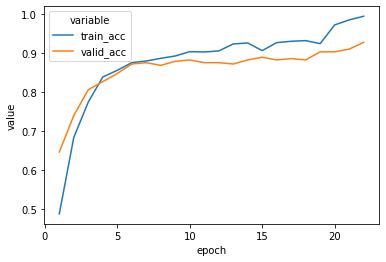

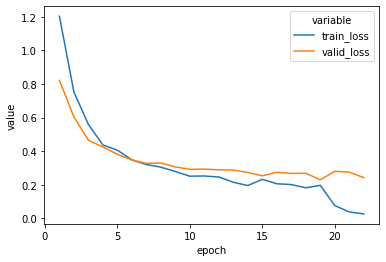

In [13]:
plot_metrics([history, tune_history])

## Final evaluation

In [12]:
# Reload best model from previous train
model.load_weights(SAVED_MODEL_PATH)

loss, accuracy = model.evaluate(test_gen)
print(f'Final accuracy on the test set: {round(accuracy*100, 2)}%')

10/10 [==============================] - 6s 627ms/step - loss: 0.1608 - accuracy: 0.9367
Final accuracy on the test set: 93.67%
